## Lab | Making predictions with logistic regression

## 01 - Problem (case study)

**DATA**

We use Sakila database of movie rentals.
We create a query  to extract  relevant information for building the prediction model. We use the data from 2005

**GOAL**

In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

In [4]:
# prep: import modules and get pwd
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


## 02 - Getting Data

In [5]:
# get the data from the query we created in SQL
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''SELECT inventory_id, store_id, COUNT(rental_id) AS times_rented, rental_duration, rental_rate, length, replacement_cost, rating, MAX(rented_august) as rented_august
FROM
(
SELECT inventory_id, store_id, rental_id, rental_duration, rental_rate, length, replacement_cost, rating, rental_date,
CASE
WHEN rental_date BETWEEN '2005-08-01' AND '2005-08-31' THEN 1
ELSE 0
END AS rented_august
FROM inventory
LEFT JOIN rental
USING(inventory_id)
LEFT JOIN film
USING(film_id)
WHERE rental_date BETWEEN '2005-01-01' AND '2005-12-31') sub1
GROUP BY inventory_id, store_id, rental_duration, rental_rate, length, replacement_cost, rating;
 '''

data = pd.read_sql_query(query, engine)
data.head(50)

,inventory_id,store_id,times_rented,rental_duration,rental_rate,length,replacement_cost,rating,rented_august
0,367,1,5,7,2.99,148,21.99,G,1
1,1525,2,5,7,2.99,126,16.99,R,1
2,1711,2,5,7,2.99,156,14.99,G,1
3,2452,1,5,6,0.99,181,21.99,R,1
4,2079,2,5,5,2.99,84,29.99,NC-17,1
5,2792,1,5,5,0.99,92,19.99,NC-17,1
6,3995,2,5,4,0.99,123,12.99,PG-13,1
7,2346,1,4,6,4.99,181,29.99,G,1
8,2580,1,5,6,4.99,56,9.99,PG-13,1
9,1824,2,5,5,4.99,62,18.99,G,1



**NUMERICAL:**
- Data describe. Quick conclusion: drop release_year and language_id cause they are all the same.
- See if scailing is needed
- Scale
- Correlation analysis and dropping columns in case of high correlation

**CATEGORICAL:**

- Deciding which columns should be categorical
- Clean categorical variables: null values
- Converting categorical: do get dummies

**FINALLY:**

- Model
- Score
- Interpretation of results

In [6]:
# Cell-to-cell script
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [7]:
data.shape

(4580, 9)

## 03 - Cleaning/Wrangling/EDA

**Initial analysis of our variables**

Our goal in this project is to know if a film is going to be rented or not, so our target variable is the column ‘rented_august’ ( label). We will rename this to 'rented'. If the value is 1 the film is going to be rented and if not the value is 0.

The rest of the variables are our features.

For our prediction goal, we think that the film_id is not relevant to include in our model. 


In [8]:
data.describe()

,inventory_id,store_id,times_rented,rental_duration,rental_rate,length,replacement_cost,rented_august
count,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000
mean,2291.499127,1.504367,3.463319,4.923799,2.951135,114.935590,20.218384,0.966376
std,1322.277958,0.500036,1.135967,1.406503,1.644880,40.063566,6.077017,0.180280
min,1.000000,1.000000,1.000000,3.000000,0.990000,46.000000,9.990000,0.000000
25%,1146.750000,1.000000,2.000000,4.000000,0.990000,81.000000,14.990000,1.000000
50%,2291.500000,2.000000,3.000000,5.000000,2.990000,114.000000,20.990000,1.000000
75%,3436.250000,2.000000,4.000000,6.000000,4.990000,148.000000,25.990000,1.000000
max,4581.000000,2.000000,5.000000,7.000000,4.990000,185.000000,29.990000,1.000000


In [406]:
#We see that std of release_year and language_id is 0. That means that all the values are the same.
#So it is not interesting to include these features in our prediction model.

In [407]:
#Let´s confirm this by getting the unique values for these two features.
data.release_year.value_counts()
data.language_id.value_counts()

2006    1521
Name: release_year, dtype: int64

1    1521
Name: language_id, dtype: int64

In [408]:
#Dropping these columns from our data set
data = data.drop(['film_id','release_year','language_id'], axis=1)
data.head()

,amount_of_copies,times_rented,store_id,rental_duration,rental_rate,length,replacement_cost,rating,rented
0,4,12,1,6,0.99,86,20.99,PG,1
1,3,11,2,6,0.99,86,20.99,PG,0
2,3,6,2,3,4.99,48,12.99,G,1
3,4,12,2,7,2.99,50,18.99,NC-17,1
4,4,13,1,5,2.99,117,26.99,G,0


In [409]:
data.dtypes

amount_of_copies      int64
times_rented          int64
store_id              int64
rental_duration       int64
rental_rate         float64
length                int64
replacement_cost    float64
rating               object
rented                int64
dtype: object

In [410]:
data.dtypes

amount_of_copies      int64
times_rented          int64
store_id              int64
rental_duration       int64
rental_rate         float64
length                int64
replacement_cost    float64
rating               object
rented                int64
dtype: object

After checking the data types we find that we have only one categorical variable (rating) but sometimesthere are some of the features that have a numerical type that do not have real meaning being numerical so we should convert them to categorical.Is the case of store_id,

In [411]:
data['store_id'] = data['store_id'].astype('object') # This will be treated as categorical

In [412]:
data.dtypes
#we have now store_id as an object type.

amount_of_copies      int64
times_rented          int64
store_id             object
rental_duration       int64
rental_rate         float64
length                int64
replacement_cost    float64
rating               object
rented                int64
dtype: object

## 04 - Processing Data

In [413]:
#Split into numerical and categorical.
data_num = data.select_dtypes(include= np.number)
data_cat = data.select_dtypes(include = object)

In [414]:
data_num.head()
# data_cat.head()
data_num.dtypes

,amount_of_copies,times_rented,rental_duration,rental_rate,length,replacement_cost,rented
0,4,12,6,0.99,86,20.99,1
1,3,11,6,0.99,86,20.99,0
2,3,6,3,4.99,48,12.99,1
3,4,12,7,2.99,50,18.99,1
4,4,13,5,2.99,117,26.99,0


amount_of_copies      int64
times_rented          int64
rental_duration       int64
rental_rate         float64
length                int64
replacement_cost    float64
rented                int64
dtype: object

In [415]:
#Let´s check null values
data_num.isna().sum()
#there are no null values

amount_of_copies    0
times_rented        0
rental_duration     0
rental_rate         0
length              0
replacement_cost    0
rented              0
dtype: int64

In [416]:
data_num.describe()

,amount_of_copies,times_rented,rental_duration,rental_rate,length,replacement_cost,rented
count,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000
mean,3.011177,10.428665,4.929652,2.958442,115.115713,20.193156,0.357659
std,0.823507,3.429219,1.409898,1.641262,40.013498,6.063709,0.479469
min,2.000000,3.000000,3.000000,0.990000,46.000000,9.990000,0.000000
25%,2.000000,8.000000,4.000000,0.990000,81.000000,14.990000,0.000000
50%,3.000000,10.000000,5.000000,2.990000,114.000000,20.990000,0.000000
75%,4.000000,13.000000,6.000000,4.990000,148.000000,24.990000,1.000000
max,4.000000,20.000000,7.000000,4.990000,185.000000,29.990000,1.000000


From the chart above we can assume that there are not important outliers because the difference
between the 3 percentile (75%) is not very far from the max value.

C:\Users\Elena\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


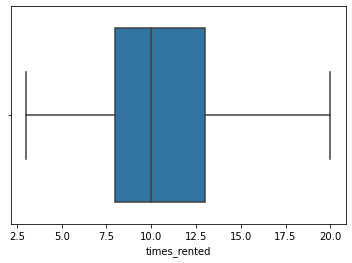

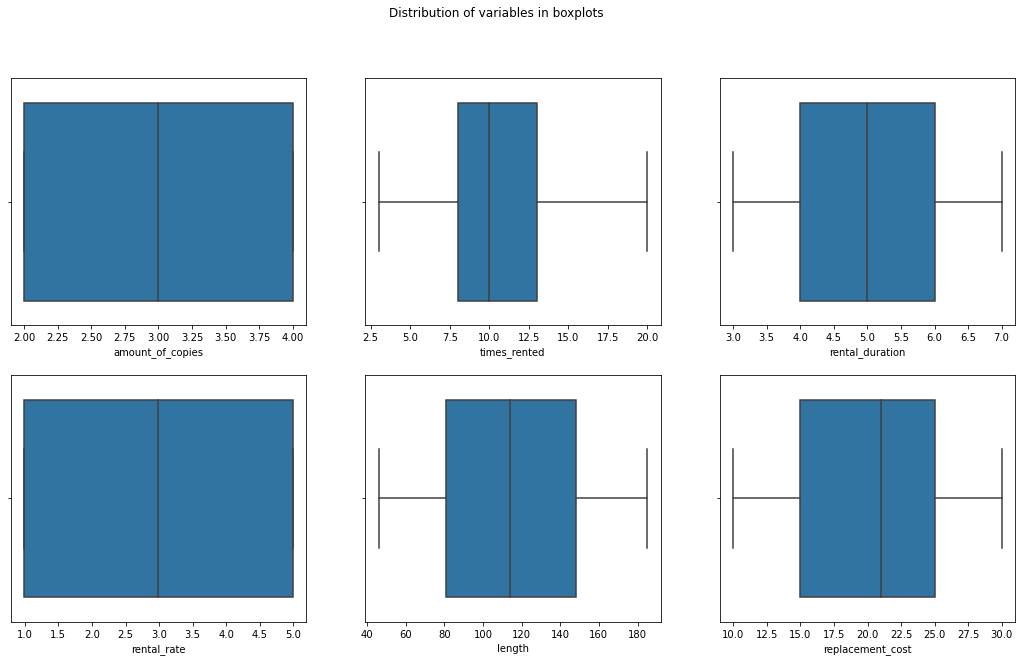

In [417]:
#let´s check our assumption with box plots: 
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(data_num['times_rented'])


fig, axes = plt.subplots(2,3,  figsize=(18, 10))
fig.suptitle('Distribution of variables in boxplots')
sns.boxplot(ax=axes[0, 0],data= data, x= 'amount_of_copies')
sns.boxplot(ax=axes[0, 1],data= data, x= 'times_rented' )
sns.boxplot(ax=axes[0, 2],data= data, x= 'rental_duration' )
sns.boxplot(ax=axes[1, 0],data= data, x= 'rental_rate')
sns.boxplot(ax=axes[1, 1],data= data, x= 'length')
sns.boxplot(ax=axes[1, 2],data= data, x= 'replacement_cost');


#we do not find outlieres so we do not have to deal with them.

<Figure size 1200x640 with 0 Axes>

<AxesSubplot:>

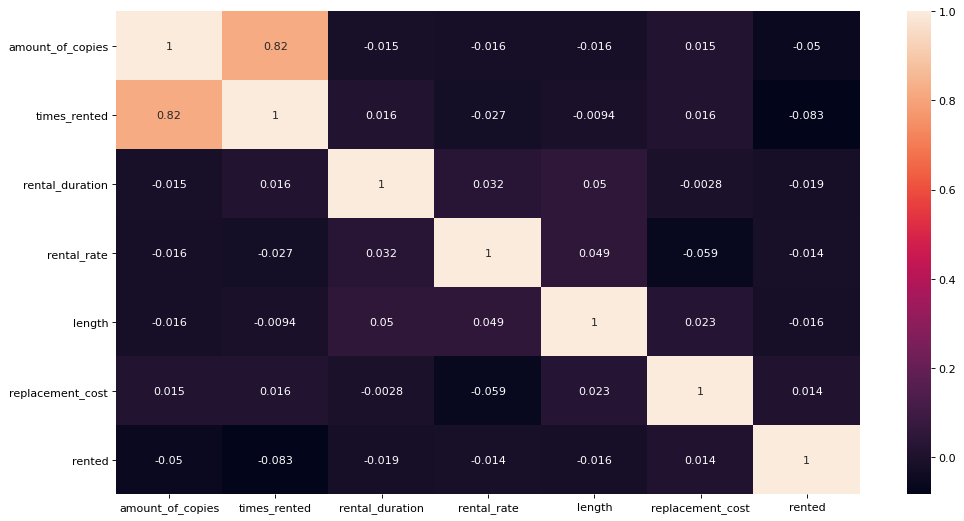

In [418]:
cormat = data_num.corr()
plt.figure(figsize=(15,8), dpi=80)
sns.heatmap(cormat, annot=True)

In [419]:
#we find that there is a high correlation between amount_of copys and time_rented. 
#We deciede to drop the amount of copies feature from our dataset 
#Dropping this column from our data set
data_num = data_num.drop(['amount_of_copies'], axis=1)
data_num.head()
#on the other hand the correlation with our label does not make sense to take into account as it is a boolean variable 

,times_rented,rental_duration,rental_rate,length,replacement_cost,rented
0,12,6,0.99,86,20.99,1
1,11,6,0.99,86,20.99,0
2,6,3,4.99,48,12.99,1
3,12,7,2.99,50,18.99,1
4,13,5,2.99,117,26.99,0


In [430]:
# # Scaling data
# from sklearn.preprocessing import MinMaxScaler

# MinMaxtransformer = MinMaxScaler().fit(data_num)
# x_normalized = MinMaxtransformer.transform(data_num)
# x_normalized.shape
# x_normalized = pd.DataFrame(x_normalized,columns=data_num.columns)
# x_normalized.head(2)

## WE DECIDED TO NOT SCALE DATA

In [421]:
#dealing with categorical. 
#Let´s check null values
data_cat.isna().sum()

store_id    0
rating      0
dtype: int64

In [422]:
#dealing with the categorical variables. Transforming to numerical to include them in our model.
data_cat = pd.get_dummies(data_cat, columns=['store_id', 'rating'], drop_first=True)
data_cat.head()

,store_id_2,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0,0,1,0,0
1,1,0,1,0,0
2,1,0,0,0,0
3,1,1,0,0,0
4,0,0,0,0,0


In [424]:
#Joining numerical and categorical dataframes.
data_final = pd.concat([data_num,data_cat], axis=1)
data_final.head()

,times_rented,rental_duration,rental_rate,length,replacement_cost,rented,store_id_2,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,12,6,0.99,86,20.99,1,0,0,1,0,0
1,11,6,0.99,86,20.99,0,1,0,1,0,0
2,6,3,4.99,48,12.99,1,1,0,0,0,0
3,12,7,2.99,50,18.99,1,1,1,0,0,0
4,13,5,2.99,117,26.99,0,0,0,0,0,0


## 05 - Modeling

In [425]:
# build X and y
y = data_final['rented']
X = data_final

In [426]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [428]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='saga',
                  multi_class='ovr').fit(X_train, y_train)

C:\Users\Elena\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## 06 - Model Validation

In [429]:
predictions = classification.predict(X_test)
classification.score(X_test, y_test)

0.912472647702407

In [433]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[294,   0],
       [ 40, 123]], dtype=int64)

In [434]:
# classification.score == accuracy of prediction
(294+123)/(294+123+40+0)

0.912472647702407